# Sequential Uncertainty Reuction and Value of Information in Gaussian Process Models

We have a forest on a $25\times25$ grid, which consists of $625$ units of cells, $(1,1), (1,2),\dots,(25,25)$. A farmer only has two choices $a = 0$,leave all cells for conservation, or $a = 1$, harvest all cells.

The uncertain profits on a cell $\mathbf{s} = (s_1, s_2)$ has $E[x(\mathbf{s})] = \mathbf{0}$, $\mathrm{Var}[x(\mathbf{s})] = 1^2$ and $\mathrm{Cov}[x(\mathbf{s}),x(\mathbf{s}')] = e^{-0.15h}$, where $h = \sqrt{||\mathbf{s}-\mathbf{s}'||^2}$. This yeilds the multivariate prior 
\begin{equation*}
\mathbf{x} \sim \mathcal{N}[\mathbf{0},\Sigma].
\end{equation*}

We do measurements along the North-South Lines in the grid. Which means that we measure $25$ cells at a time along the line $y(\mathbf{s}) = x(\mathbf{s}) + \mathcal{N}[0,5^2]$. This means we can measure $25$ different lines that are modelled by
\begin{equation*}
\mathbf{y}_j = \mathbf{F}_j\mathbf{x} + \mathcal{N}[\mathbf{0},\mathbf{T}].
\end{equation*}

All this yeilds the new mean and covariance at the $j$th line 
\begin{equation*}
\begin{array}{rcl}
\mathbf{\mu}_j & = & \mathbf{\mu} + \mathbf{\Sigma}\mathbf{F}_j^T(\mathbf{F}_j\mathbf{\Sigma}\mathbf{F}_j^T + \mathbf{T})^{-1}(\mathbf{y}_j - \mathbf{F}_j\mathbf{\mu})\\
\mathbf{\Sigma}_j & = & \mathbf{\Sigma} - \mathbf{\Sigma}\mathbf{F}_j^T(\mathbf{F}_j\mathbf{\Sigma}\mathbf{F}_j^T + \mathbf{T})^{-1}\mathbf{F_j}\mathbf{\Sigma}.
\end{array}
\end{equation*}

In [25]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm # importing norm cdf and pdf
import pandas as pd # to plot dictionaries
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.ticker as ticker

In [2]:
N = 25
m = 625
def create_grid(m,N):
    Sigma = np.identity(m)
    s = np.zeros((2,m))
    T = np.identity(N)*5**2
    mu = np.zeros(m)
    for i in range(N):
        for j in range(N):
            s[:,j + i*N] = [i+1,j+1]
    for i in range(m-1):
        for j in range(i+1,m):
            Sigma[i,j] = Sigma[j,i] = np.exp(-0.15*np.sqrt((s[0,i] - s[0,j])**2 + (s[1,i] - s[1,j])**2))
    return s, mu, Sigma, T

def get_F_j(m,N,j):
    F_j = np.zeros((N,m))
    for i in range(N):
        for k in range(N):
            F_j[i,k*N + j-1] = 1
    return F_j

def get_Sigma_j(m,N,j,Sigma,T):
    F_j = get_F_j(m,N,j)
    tmp = (F_j@Sigma@F_j.transpose() + T)
    tmp = np.linalg.inv(tmp)
    Sigma_j = Sigma - Sigma@F_j.transpose()@tmp@F_j@Sigma
    return Sigma_j, F_j

In [3]:
s, mu, Sigma, T = create_grid(m,N)

### a)
Select the line j that m,aximises the reduction in the mean variance of the grid: i.e. the one that gives the smallest $\frac{1}{625}\sum_{k=1}^{625} \Sigma_j(k,k)$.


In [4]:
def max_reduc_mean_var(m,N,Sigma,T):
    tmp_min = np.inf
    tmp_min_j = np.nan
    for j in range(1,26):
        Sigma_j, F_j = get_Sigma_j(m,N,j,Sigma,T)
        tmp_mean_var = np.diag(Sigma_j).mean()
        if tmp_mean_var < tmp_min:
            tmp_min = tmp_mean_var
            tmp_min_j = j
    return tmp_min_j

In [5]:
min_j= max_reduc_mean_var(m,N,Sigma,T)
print("Line {} maximizes the reduction in mean variance".format(min_j))

Line 13 maximizes the reduction in mean variance


Now we need to do this sequentially and update the values according to the algorithm

\begin{equation*}
\begin{array}{c}
    \mathbf{\Sigma}_j = \mathbf{\Sigma} - \mathbf{\Sigma}\mathbf{F}_j^T(\mathbf{F}_j\mathbf{\Sigma}\mathbf{F}_j^T + \mathbf{T})^{-1}\mathbf{F_j}\mathbf{\Sigma}.
\end{array}
\end{equation*}

In [6]:
Sigma_j, F_j = get_Sigma_j(m,N,min_j,Sigma,T)

In [7]:
def sample_y_j(mu,Sigma,F_j,T):
    return np.random.multivariate_normal(F_j @ mu, F_j @ Sigma @ F_j.transpose() + T)

def ten_lines(m,N):
    s, mu, Sigma, T = create_grid(m,N)
    for i in range(10):
        min_j = max_reduc_mean_var(m,N,Sigma,T)
        Sigma_j, F_j = get_Sigma_j(m,N,min_j,Sigma,T)
        y_j = sample_y_j(mu,Sigma,F_j,T)
        mu += Sigma @ F_j.transpose()@np.linalg.inv(T + F_j@Sigma@F_j.transpose())@(y_j-F_j@mu)
        Sigma = Sigma_j
        print("Line {} maximizes the reduction in mean variance".format(min_j))
    return mu, Sigma
        
    

In [8]:
mu, Sigma = ten_lines(m,N)

Line 13 maximizes the reduction in mean variance
Line 22 maximizes the reduction in mean variance
Line 4 maximizes the reduction in mean variance
Line 9 maximizes the reduction in mean variance
Line 18 maximizes the reduction in mean variance
Line 1 maximizes the reduction in mean variance
Line 25 maximizes the reduction in mean variance
Line 15 maximizes the reduction in mean variance
Line 7 maximizes the reduction in mean variance
Line 20 maximizes the reduction in mean variance


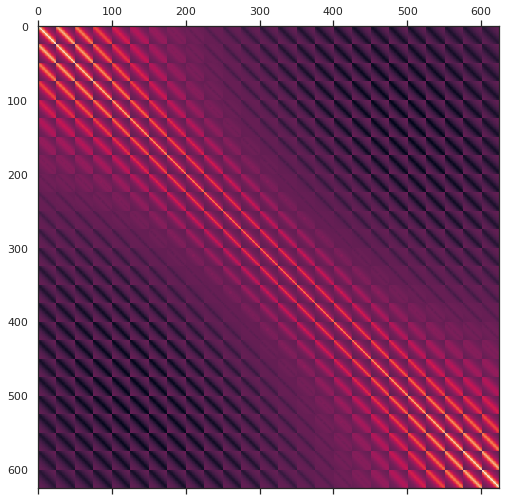

In [28]:
plt.matshow(Sigma);

The figure above is a visualization of the covariance matrix $\mathbf{\Sigma}$. There is a clear pattern in the $25\times25$ squares within. Under a visualization of the $\mathbf{F}_j$ matrix is presented. 

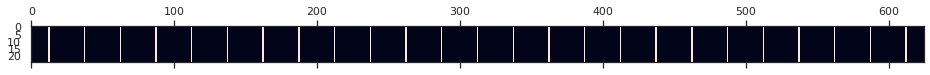

In [57]:
plt.matshow(F_j);

### b)
One is interested in worthwhile information gathering for making improved decisions.
The prior value is $PV = max\{0,\sum_{k=1}^{625} \mu(k)$ and the value of information is given by
\begin{equation*}
    \mathrm{VOI}_j = [\mu_w\Phi(\mu_w/r_{w,j}) +  r_{w,j}\phi(\mu_w/r_{w,j})] - PV,
\end{equation*} 
where $\Phi(\cdot)$ and $\phi(\cdot)$ is the Gaussian cdf and pdf respectivly. Also $\mu_w = \sum_{k=1}^{625} \mu(k)$ and $r_{w,j}^2 = \sum_k\sum_l R_j(k,l)$ where $\mathbf{R}_j =\mathbf{\Sigma}\mathbf{F}_j^T(\mathbf{F}_j\mathbf{\Sigma}\mathbf{F}_j^T + \mathbf{T})^{-1}\mathbf{F_j}\mathbf{\Sigma}$. We are to sequentially gather data at the best line given the current information and stop information gathering if the VOI is less than the price $P=0.5$. This is the Myopic scheme and it is greedy.

\begin{equation*}
\boxed{\begin{array}{ll}
    \textrm{Initiate:} & \mathbf{x}, \mathbf{\mu}, \mathbf{\Sigma}, m = 625, N = 25 \\ 
    \textrm{Find:} & j^* = \underset{j}{\mathrm{min}} \frac{1}{m}\sum_{k=1}^m \Sigma_j(k,k)\\
    \textrm{Calc:} & \mathbf{R}_{j^*}, \mu_w, r_{w,j^*}, \mathrm{VOI}_{j^*}\\
    \textrm{While }\mathrm{VOI}_{j^*} > P:  &  \\ 
    \hspace{25pt}\textrm{Collect data:} & \mathbf{y}_{j^*}\\
    \hspace{25pt}\textrm{Update model:} & \mathbf{\mu}\mathrel{{+}{=}} \mathbf{\Sigma}\mathbf{F}_{j^*}^T(\mathbf{F}_{j^*}\mathbf{\Sigma}\mathbf{F}_{j^*}^T + \mathbf{T})^{-1}(\mathbf{y}_{j^*} - \mathbf{F}_{j^*}\mathbf{\mu}) \\ 
    & \mathbf{\Sigma} \mathrel{{-}{=}} \mathbf{R}_{j^*}\\ 
    \hspace{25pt}\textrm{Find:} & j^* = \underset{j}{\mathrm{min}} \frac{1}{m}\sum_{k=1}^m \Sigma_j(k,k)\\
\end{array}}
\end{equation*}

In [10]:
# function calculating the value of information
def value_of_information(mu_w,r_w,PV):
    return mu_w*norm.cdf(mu_w/r_w) + r_w*norm.pdf(mu_w/r_w) - PV

# code of the myopic scheme
def sequential_voi(m,N):
    s, mu, Sigma, T = create_grid(m,N)
    min_j = max_reduc_mean_var(m,N,Sigma,T)
    Sigma_j, F_j = get_Sigma_j(m,N,min_j,Sigma,T)
    y_j = sample_y_j(mu,Sigma,F_j,T)
    tmp_mu = mu + Sigma @ F_j.transpose()@np.linalg.inv(T + F_j@Sigma@F_j.transpose())@(y_j-F_j@mu)
    mu_w = tmp_mu.sum()
    r_w = np.sqrt((Sigma-Sigma_j).sum())
    PV = 0
    voi = value_of_information(mu_w,r_w,PV)
    lines = []
    voi_list = []
    n_lines = 0
    while voi > 0.5:
        lines.append(min_j)
        voi_list.append(voi)
        n_lines += 1
        mu = tmp_mu
        Sigma = Sigma_j
        PV = np.max([mu.sum(),0])
        min_j = max_reduc_mean_var(m,N,Sigma,T)
        Sigma_j, F_j = get_Sigma_j(m,N,min_j,Sigma,T)
        y_j = sample_y_j(mu,Sigma,F_j,T)
        tmp_mu = mu + Sigma @ F_j.transpose()@np.linalg.inv(T + F_j@Sigma@F_j.transpose())@(y_j-F_j@mu)
        mu_w = tmp_mu.sum()
        r_w = np.sqrt((Sigma-Sigma_j).sum())
        voi = value_of_information(mu_w,r_w,PV)
    return lines, int(n_lines),voi_list

Below we have included an example run of the algorithm presented above.

In [11]:
lines, n_lines,voi = sequential_voi(m,N)
print("Example run selected {}, and the lines where {}".format(n_lines,lines))

Example run selected 1, and the lines where [13]


Now we want to create $100$ replicated trials.

In [12]:
rep_trials = 100
lines_df = pd.DataFrame({"lines":[],
                        "trial":[],
                        "voi":[]})
for i in range(rep_trials):
    lines, n_lines, voi = sequential_voi(m,N)
    lines_df = lines_df.append(
        pd.DataFrame({"lines":lines,
                      "trial":[i+1]*int(n_lines),
                      "voi":voi}),
        ignore_index = True)
    print("Trial {}: {} lines".format(i+1,n_lines),end="\r")

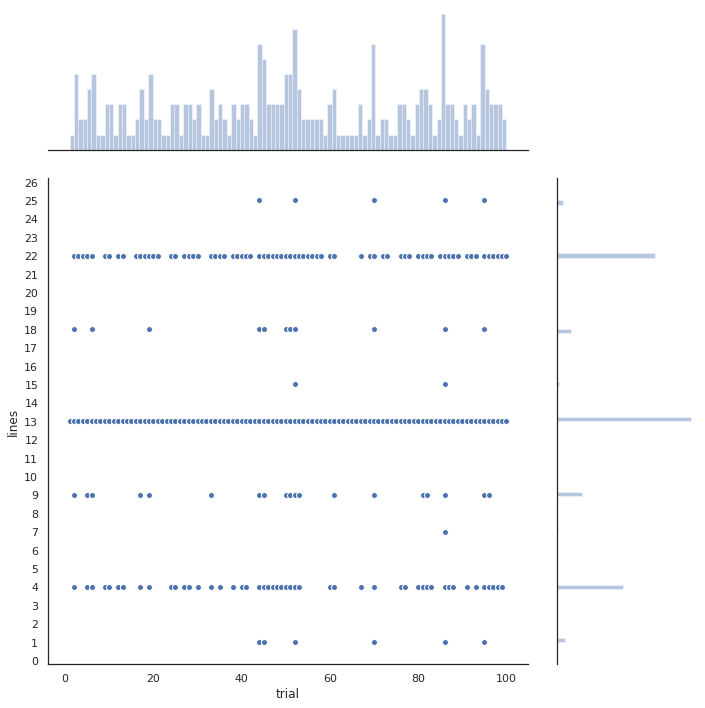

In [26]:
g = sns.jointplot(x="trial", y="lines", data=lines_df,
              marginal_kws=dict(bins=100),
              height=10, ratio=3, color="b",
              annot_kws=dict(stat="r"), edgecolor="w", linewidth=1)
g.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(1))

The figure above shows the different replicated trials along the x-axis with their respective selection of lines along the y-axis. The histogram on top shows the number of selected lines for each trial, and the histogram to the right shows the histogram of number of times the a line is chosen in all the trials.

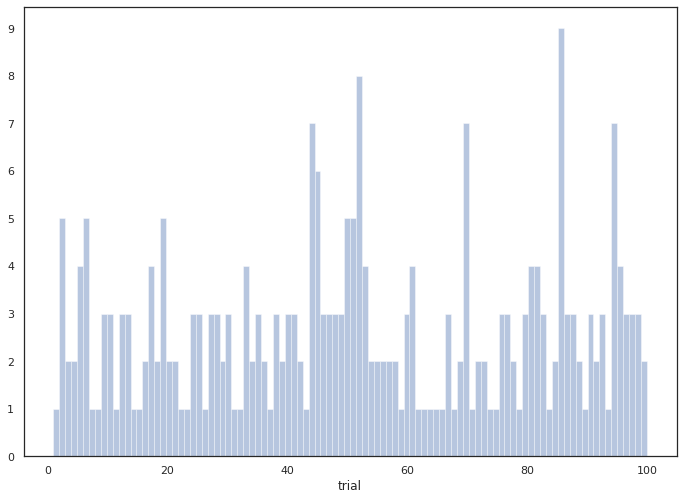

In [30]:
ax = sns.distplot(lines_df["trial"], bins = 100,kde=False)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

The figure above presents the histogram also included in the previous figure. It displays the number of selected lines in each trial.

We can see that line 13 is chosen every time, followed by the most occuring is line 22 and 4. Lines 18 and 9 has also been chosen some trials. Also occuring is line 25 and 1. Lines 7 and 15 have occured ones or twice. In the last plot we can see that we have at most chosen 9 lines. 

The Myopic scheme as previously mentioned is a greedy scheme, and it doesn't look beyond the next step to evaluate if more information is good. If we were to look at 10 runs for every trial and then look at the VOI in the later steps, this might be higher than $0.5$. 

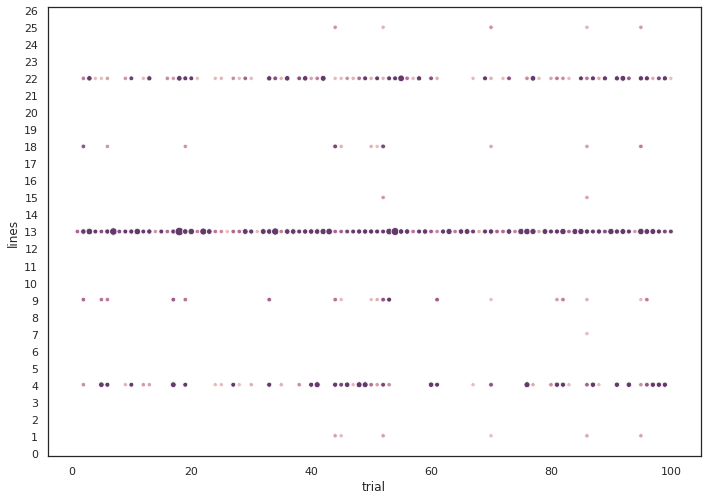

In [44]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="trial",y="lines",hue="voi",size = "voi",data=lines_df,legend=False,palette=cmap,hue_norm=(0,50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

The figure above shows the value of information as the darkness of the color and the size of the point

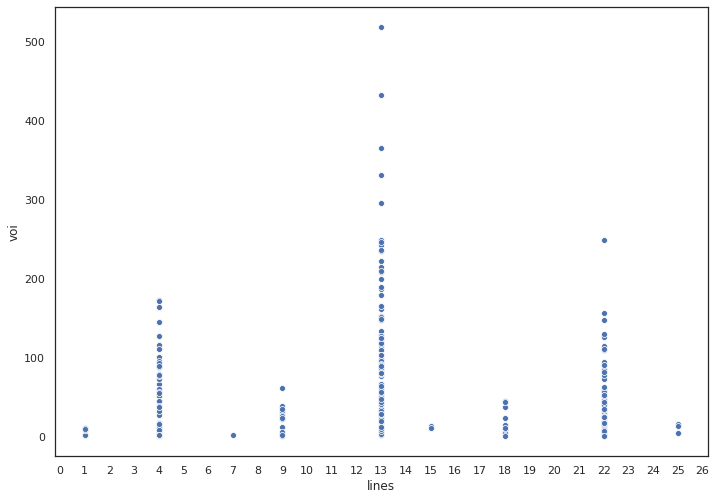

In [55]:
ax = sns.scatterplot(x="lines",y="voi",data=lines_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

The figure above shows the value of information on the y-axis according to which line is selected.